# Car price prediction project (module 5)

## Import

In [509]:
# general packages
import time

import sklearn as sklearn
from ordered_set import OrderedSet
from functools import wraps
import re

from IPython.display import display

# tabular data analysis/processing
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas_profiling import ProfileReport

# visualization
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import plotly.graph_objects as go

# machine learning
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

print('Import is completed.')

Import is completed.


## Init setup

In [541]:
# fix random seed
SEED = 37

# visualization flag. Global turn and off time-consumed visualization.
# to iterate different experiments faster when we don't need to visualize everything
# better solution would be to mark some cells from evaluation, but didn't find any good workaround..
VISUALIZE = False

# # number of threads for computations
# N_THREADS = max(1, multiprocessing.cpu_count() - 1)

# configure visualization aesthetics
plt.style.use('default')
sb.set_style('dark')

# fix requirements
!pip freeze > requirements.txt

### Constants

In [315]:
# RARITY_YEAR = 1975

## Functions

In [316]:
def exists(var_name:str):
    """Check if a variable with var_name exists in global scope"""
    return var_name in globals()

def print_framed(text: str, frame_width=100):
    """Print text in frame of asterisks ('*')"""
    text_width = len(text)
    gap = 5
    edge_width = (frame_width - text_width) // 2 - gap
    print('*'*frame_width)
    print('*'*edge_width + ' '*gap + text + ' '*gap + '*'*edge_width)
    print('*'*frame_width)

def correct_name(f_name:str):
    """Feature name correction"""
    new_name = f_name[0].upper()+f_name[1:]
    splitted = new_name.split('_')
    if len(splitted)>1:
        new_name = splitted[0]+splitted[1][0].upper()+splitted[1][1:]
    return new_name

def log_transform(arr: np.ndarray):
    """
    Log transformation of the data in specified numpy array
    """
    return np.log(arr+1)

def inv_log_transform(arr: np.ndarray):
    """
    Inverse log transformation of the data in specified numpy array
    """
    return np.exp(arr)-1

def fillna_mode(df, col):
    """
    Function fills NaN values in column of df with MODE value.
    :param col: Column to replace NaN with mode
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].mode().iloc[0]}, inplace=True)

def print_num_col_statistics(col:Series):

    print(f'Statistics for {col.name} column:')
    col_stat = col.describe()
    col_stat['Median'] = col.median()
    mode, count = next(col.value_counts(ascending=False).items())
    col_stat['Mode/Count'] = f'{mode}/{count}'
    col_stat['Skewness'] = col.skew()

    q1, q3 = col.quantile([0.25, 0.75])
    IQR = q3 - q1
    n_outliers = sum(~col.between(q1 - 1.5 * IQR, q3 + 1.5 * IQR))

    col_stat['IQR'] = IQR
    col_stat['Number of outliers'] = f'{n_outliers} ({n_outliers / col.shape[0]:.1%})'
    display(col_stat)

# === Visualisation functions ===
def visualisation_check(func):
    """Visualising functions decorator"""
    def func_wrapper(*args, **kwargs):
        wraps(func)
        if VISUALIZE:
            func(*args, **kwargs)
        else:
            print(f'Visualising function {func.__name__}() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).')

    return func_wrapper

@visualisation_check
def vis_analyze_num_col(df:DataFrame,
                        col:str,
                        target:str=None,
                        hist_bins:int=10,
                        hist2d_x_bins:int=50,
                        hist2d_y_bins:int=3,
                        showfliers:bool=True,
                        interactive_hist2d:bool=False,
                        title_add:str=''):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Column '+col+' analysis '+title_add)

    # histogram
    df[col].plot.hist(ax=ax[0], bins=hist_bins)
    # boxplot
    sb.boxplot(data=df, y=col, ax=ax[1], orient='v', showfliers=showfliers, medianprops={'color':'red'}, showmeans=True)
    plt.show()

    # plots with target if any
    if target:
        if not interactive_hist2d:
            # # _, ax = plt.subplots(1,1, figsize=(15,7))
            # joint_plot = sb.jointplot(data=df, x=col, y=target, ax=ax)
            # joint_plot.fig.set_figwidth(15)
            # plt.show()

            plt.rcParams["figure.autolayout"] = False

            jp = sb.jointplot(data=df, x=col, y=target, kind='hist', bins=(hist2d_x_bins,hist2d_y_bins), color='blue')
            jp.fig.set_figwidth(15,5)
            # jp.ax_joint.cla()
            plt.sca(jp.ax_joint)
            fig, ax = plt.gcf(), plt.gca()

            x_l, x_r = jp.ax_joint.get_xlim()
            y_b, y_u = jp.ax_joint.get_ylim()

            _,_,_,img = plt.hist2d(data=df, x=col, y=target, cmap='YlOrRd', bins=(hist2d_x_bins,hist2d_y_bins))

            plt.xlim([x_l, x_r])
            plt.ylim([y_b, y_u])

            plt.scatter(data=df, x=col, y=target, s=7, c='blue', alpha=0.5)

            # plot bins median line
            df_bins = df[[col, target]].copy()
            df_bins['Bins'] = pd.cut(x=df_bins[col], bins=hist2d_x_bins)
            bin_medians = df_bins.groupby('Bins').median()[target]
            bin_medians.index = map(lambda i: (i.left + i.right)/2,bin_medians.index)
            bin_medians.plot(style='-s', color='green', ms=5)

            plt.legend(labels=[target, col+' bins median'], bbox_to_anchor=(1.02,1.1), loc="lower left", ncol=2)

            cbar_ax = fig.add_axes([1, 0.1, .03, .7])
            plt.colorbar(mappable=img, cax=cbar_ax)
            plt.show()

            plt.rcParams["figure.autolayout"] = True

        else:
            # 2d hist with scatter chart
            fig_2 = go.Figure()

            fig_2.add_trace(go.Scatter(
                x=df[col],
                y=df[target],
                mode='markers',
                showlegend=False,
                marker=dict(
                    symbol='circle',
                    opacity=0.5,
                    color='blue',
                    size=3,
                    # line=dict(width=1),
                )
            ))
            fig_2.add_trace(go.Histogram2d(
                x=df[col],
                y=df[target],
                colorscale='YlOrRd',
                # zmax=10,
                nbinsx=hist2d_x_bins,
                nbinsy=hist2d_y_bins,
                # zauto=False,
            ))

            fig_2.update_layout(
                xaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=30 ),
                yaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=30 ),
                autosize=False,
                height=500,
                width=1000,
                hovermode='closest'
            )

            fig_2.show()
    else: # no target defined - show point plot for num col
        plt.figure(figsize=(15,7))
        df[col].sort_values().reset_index(drop=True).plot(style='.', ms=5)
        df[col].hist(orientation='horizontal', bins=hist_bins, alpha=0.5)
        plt.show()

@visualisation_check
def analyze_num_col(df:DataFrame ,
                    col:str,
                    target:str=None,
                    hist_bins:int=10,
                    hist2d_x_bins:int=100,
                    hist2d_y_bins:int=3,
                    showfliers:bool=True,
                    need_log:bool = False,
                    interactive_hist2d:bool=False,):
    """Analyze numeric column with visualization

    param: df: DataFrame with column to analyze
    param: col: Name of the numeric column to analyze
    param: target: Name of the target column in the DataFrame
    """

    vis_analyze_num_col(df, col, target, hist_bins, hist2d_x_bins, hist2d_y_bins,
                        showfliers=showfliers,
                        interactive_hist2d=interactive_hist2d)
    print_num_col_statistics(df[col])

    to_corr_analysis = [df[col]]

    if need_log:
        print()
        print(f'Column {col} log transform analysis:')
        col_log = col+'_log'
        df_log = pd.DataFrame()
        df_log[col_log] = df[col].apply(log_transform)
        # df_log = pd.DataFrame(col_log_data)
        df_log[col]  = df[col]
        if target:
            df_log[target]  = df[target]

        vis_analyze_num_col(df_log, col_log, target, hist_bins, hist2d_x_bins, hist2d_y_bins,
                            showfliers=showfliers,
                            interactive_hist2d=interactive_hist2d,
                            title_add='(Log transformed)')
        print_num_col_statistics(df_log[col_log])

        to_corr_analysis.append(df_log[col_log])

    if target:
        to_corr_analysis.append(df[target])

    # display corr analysis
    display(pd.concat(to_corr_analysis, axis=1).corr())

@visualisation_check
def show_boxplot(df:DataFrame, qual_col:str, y_col:str, showfliers=True, ordering=None):
    """
    Show boxplots for qualitative value in specified column

    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param y_col: y variable for boxplot
    :param showfliers: parameter for show/hide outliers
    :param ordering: Flag of boxplots ordering (by median)
    """

    n_unique = df[qual_col].nunique()
    fig, ax = plt.subplots(figsize = (n_unique, 10))

    order = None
    if ordering:
        ordered = df.loc[:,[qual_col, y_col]].groupby([qual_col]).median().sort_values(ascending=False,by=y_col)
        order = ordered.index

    sb.boxplot(x=qual_col, y=y_col, data=df, ax=ax, showfliers=showfliers, medianprops={'color':'red'}, showmeans=True, order=order)

    ax.set_title(f'Boxplot for {qual_col}')
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    plt.show()

@visualisation_check
def show_countplot(df:DataFrame, qual_col:str, vals=None, ordering=None):
    """
    Show countplot for qualitative value in specified column

    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param ordering: Flag of boxplots ordering (by median)
    """

    data_to_plot = df[df[qual_col].isin(vals)][qual_col] if vals else df[qual_col]

    n_unique = data_to_plot.nunique()
    fig, ax = plt.subplots(figsize = (n_unique, 10))

    order = None
    if ordering:
        ordered = data_to_plot.value_counts(ascending=False)
        order = ordered.index

    sb.countplot(x=data_to_plot, order=order)

    ax.set_title(f'Countplot for {qual_col}')
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)

    plt.show()

def mape(y_pred: np.ndarray, y_true: np.ndarray):
    """
    Calculate the mean absolute percentage error (MAPE).
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [317]:
# class OneHotEncInfo:
#     def __init__(self, feature):
#         self.feature = feature


## Data loading

Load parsed in [separate notebook](https://github.com/PavelKucherenko/sf-ds50-course/blob/main/module_5/Parsing/Parsing.ipynb) train data and provided test project data.

In [318]:
TRAIN_DIR = 'Parsing/Data'
TEST_DIR = 'Data'

In [319]:
# del df_test_orig, df_train_orig
print_framed('TRAIN DATASET')
if not exists('df_train_orig'): df_train_orig = pd.read_csv(f'{TRAIN_DIR}/parsed_car_data_all__06_02_2022.csv')
# noinspection PyUnboundLocalVariable
display(df_train_orig.head(5))
df_train_orig.info()
display(df_train_orig.describe())

print_framed('TEST DATASET')
if not exists('df_test_orig'): df_test_orig = pd.read_csv(f'{TEST_DIR}/test.csv')
# noinspection PyUnboundLocalVariable
display(df_test_orig.head(5))
df_test_orig.info()
display(df_test_orig.describe())

****************************************************************************************************
**************************************     TRAIN DATASET     **************************************
****************************************************************************************************


,№,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price
0,0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{'id': '20291328', 'name': 'Laurin&Klement', '...",1 владелец.\r\nРодной пробег.\r\nПТС оригинал....,1.8,180.0,"{'cruise-control': True, 'esp': True, 'adaptiv...",...,роботизированная,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1030000.0
1,1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,красный,{'id': '0'},Skoda Octavia\r\n\r\n❕ ПТС ОРИГИНАЛ\r\n❕ ДВА В...,1.8,150.0,"{'condition': True, 'mirrors-heat': True, 'ele...",...,механическая,NaN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,400000.0
2,2,NaN,SKODA,https://auto.ru/cars/new/group/skoda/karoq/225...,белый,"{'id': '22687243', 'name': 'Hockey Edition', '...",В стоимость автомобиля включено дополнительное...,NaN,NaN,"{'cruise-control': True, 'asr': True, 'tinted-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2655000.0
3,3,NaN,SKODA,https://auto.ru/cars/new/group/skoda/rapid/217...,коричневый,"{'id': '22870340', 'name': 'Hockey Edition', '...",———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...,NaN,NaN,"{'cruise-control': True, 'asr': True, 'tinted-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1335000.0
4,4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,чёрный,{'id': '0'},ЛОТ: 01306544\r\nЛокация №16\r\nФаворит Моторс...,1.6,110.0,"{'cruise-control': True, 'glonass': True, 'asr...",...,автоматическая,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1820000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42441 entries, 0 to 42440
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   №                     42441 non-null  int64  
 1   bodyType              33328 non-null  object 
 2   brand                 41768 non-null  object 
 3   car_url               42441 non-null  object 
 4   color                 41768 non-null  object 
 5   complectation_dict    38643 non-null  object 
 6   description           41768 non-null  object 
 7   engineDisplacement    32637 non-null  float64
 8   enginePower           32757 non-null  float64
 9   equipment_dict        41685 non-null  object 
 10  fuelType              32757 non-null  object 
 11  image                 30738 non-null  object 
 12  mileage               33328 non-null  float64
 13  modelDate             40194 non-null  float64
 14  model_info            41685 non-null  object 
 15  model_name         

,№,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleConfiguration,vendor,Price
count,42441.000000,32637.000000,32757.000000,3.332800e+04,40194.000000,41685.000000,4.244100e+04,41768.000000,0.0,0.0,0.0,3.779000e+04
mean,21084.445701,2.381457,193.728547,1.306305e+05,2012.170598,4.651889,1.643820e+09,2014.457695,NaN,NaN,NaN,2.788796e+06
std,12251.038731,0.970799,88.229736,9.348202e+04,6.810206,0.578531,1.852711e+04,6.733014,NaN,NaN,NaN,2.904376e+06
min,0.000000,0.700000,45.000000,1.000000e+03,1937.000000,2.000000,1.643814e+09,1948.000000,NaN,NaN,NaN,4.000000e+04
25%,10474.000000,1.800000,136.000000,6.000000e+04,2009.000000,4.000000,1.643816e+09,2011.000000,NaN,NaN,NaN,1.090000e+06
50%,21084.000000,2.000000,170.000000,1.160000e+05,2014.000000,5.000000,1.643819e+09,2016.000000,NaN,NaN,NaN,1.930000e+06
75%,31694.000000,3.000000,240.000000,1.810000e+05,2017.000000,5.000000,1.643821e+09,2020.000000,NaN,NaN,NaN,3.460000e+06
max,42304.000000,6.600000,900.000000,1.090000e+06,2021.000000,5.000000,1.644143e+09,2022.000000,NaN,NaN,NaN,1.111000e+08


****************************************************************************************************
***************************************     TEST DATASET     ***************************************
****************************************************************************************************


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09


So, after parse stage we have all necessary columns in train set to predict car price based on test data. But we'll look at those data more thoroughly later.

## Preliminary data analysis and preprocessing

In [320]:
# create work copy of datasets
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()

In [321]:
# and their combined dict
# (without merging them into one dataframe to avoid data leakage in analysis and in model phase)
dfs = {'train':df_train, 'test':df_test}

Now we have working copy of our dataset and a combined list.
NB! For all common actions to be done on BOTH datasets we'll use this list. /Was searching for best practice here and this is my choice for now/

### Data cleaning

There are some unuseful columns in both datasets. Let's analyze them and maybe delete.

In [322]:
# run profiling on both sets
# ProfileReport(df_train).to_file(output_file='Reports/train_profiling.html')
# ProfileReport(df_test).to_file(output_file='Reports/test_profiling.html')

Analyzing pandas profiling results and other statistics, there are following columns to DELETE from both datasets:
'car_url'               - potentially we could get some additional info from car page but for this case we don't need this "overhead"
'complectation_dict'    - 81.5% missing in test - too many
'equipment_dict'        - 28.8%  missing in test. Theoretically we could take from test set records without this missings and predict via specific model, which was trained with this
                        feature (there are only 1.8% missing values in train), but for this study case let's delete this column due to large amount of missing values anyway
'image'                 - don't go with CV for now, so don't need this column
'model_info'            - have potentially useful information from here in other columns
'name'                  - have this information in other columns
'priceCurrency'         - rubles everywhere (in test and in train)
'sell_id'               - not useful
'vehicleConfiguration'  - have this information in other columns
'Владение'              - 65.4% misssing in test
'Состояние'             - single-valued column in test and in train
'Таможня'               - single-valued column in test and in train

In [323]:
# as a result - cols to be deleted from both sets:
cols_to_del = ['car_url',
                  'complectation_dict',
                  'equipment_dict',
                  'image',
                  'model_info',
                  'name',
                  'priceCurrency',
                  'sell_id',
                  'vehicleConfiguration',
                  'Владение',
                  'Состояние',
                  'Таможня']
for df in dfs.values():
    df.drop(columns=cols_to_del, inplace=True)
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42441 entries, 0 to 42440
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   №                    42441 non-null  int64  
 1   bodyType             33328 non-null  object 
 2   brand                41768 non-null  object 
 3   color                41768 non-null  object 
 4   description          41768 non-null  object 
 5   engineDisplacement   32637 non-null  float64
 6   enginePower          32757 non-null  float64
 7   fuelType             32757 non-null  object 
 8   mileage              33328 non-null  float64
 9   modelDate            40194 non-null  float64
 10  model_name           41685 non-null  object 
 11  numberOfDoors        41685 non-null  float64
 12  parsing_unixtime     42441 non-null  int64  
 13  productionDate       41768 non-null  float64
 14  super_gen            41685 non-null  object 
 15  vehicleTransmission  33328 non-null 

Ok, it's easier now)

In [324]:
# also delete 'number' column from train
df_train.drop(columns='№', inplace=True)

In [325]:
# and check if the columns are equal and with same order (without last target 'Price' in train)
list(df_train.columns[:-1]) == list(df_test.columns)

True

Ok, we have same features in train and in test.

We also have some missing values 'bodyType' in train set, let's deal with them.

In [326]:
df_train[df_train['bodyType'].isna()].shape

(9113, 21)

In [327]:
df_train[df_train['bodyType'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,parsing_unixtime,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Price
2,NaN,SKODA,белый,В стоимость автомобиля включено дополнительное...,NaN,NaN,NaN,NaN,2017.0,KAROQ,...,1643813748,2022.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,2655000.0
3,NaN,SKODA,коричневый,———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...,NaN,NaN,NaN,NaN,2020.0,RAPID,...,1643813747,2022.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,1335000.0
9,NaN,SKODA,синий,———————————————————————————\r\nФУНКЦИОНАЛЬНОЕ ...,NaN,NaN,NaN,NaN,NaN,RAPID,...,1643813747,2022.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,SKODA,синий,В стоимость автомобиля включено дополнительное...,NaN,NaN,NaN,NaN,2020.0,RAPID,...,1643813748,2022.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,1815000.0
19,NaN,SKODA,коричневый,В стоимость автомобиля включено дополнительное...,NaN,NaN,NaN,NaN,2020.0,RAPID,...,1643813748,2022.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,1535000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,NaN,MITSUBISHI,белый,В честь 30-летия бренда Mitsubishi в России ст...,NaN,NaN,NaN,NaN,2020.0,ASX,...,1643823712,2021.0,"{'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,2246000.0
42302,NaN,MITSUBISHI,белый,Специальные условия на покупку Mitsubishi ASX ...,NaN,NaN,NaN,NaN,2020.0,ASX,...,1643823712,2021.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",NaN,NaN,NaN,NaN,NaN,NaN,1600000.0
42318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1644142619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1644142632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
no_bodyType_mask = df_train['bodyType'].isna()
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['fuelType'].isna()))
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['mileage'].isna()))
print(sum(no_bodyType_mask ^ df_train[no_bodyType_mask]['vehicleTransmission'].isna()))

0
0
0


Exactly these rows have a lot of missing values in other important columns - unfortunately not useful. Delete them.

In [329]:
df_train.drop(labels=df_train[df_train['bodyType'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33328 entries, 0 to 33327
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             33328 non-null  object 
 1   brand                33328 non-null  object 
 2   color                33328 non-null  object 
 3   description          33328 non-null  object 
 4   engineDisplacement   32637 non-null  float64
 5   enginePower          32757 non-null  float64
 6   fuelType             32757 non-null  object 
 7   mileage              33328 non-null  float64
 8   modelDate            32858 non-null  float64
 9   model_name           33328 non-null  object 
 10  numberOfDoors        33328 non-null  float64
 11  parsing_unixtime     33328 non-null  int64  
 12  productionDate       33328 non-null  float64
 13  super_gen            33328 non-null  object 
 14  vehicleTransmission  33328 non-null  object 
 15  vendor               0 non-null     

Now check and delete missing price rows in train set.

In [330]:
df_train[df_train['Price'].isna()].shape

(2770, 21)

In [331]:
df_train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,parsing_unixtime,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Price
0,лифтбек,SKODA,коричневый,1 владелец.\r\nРодной пробег.\r\nПТС оригинал....,1.8,180.0,Бензин,98000.0,2013.0,OCTAVIA,...,1643813748,2014.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,1 владелец,Оригинал,передний,Левый,1030000.0
1,лифтбек,SKODA,красный,Skoda Octavia\r\n\r\n❕ ПТС ОРИГИНАЛ\r\n❕ ДВА В...,1.8,150.0,Бензин,239000.0,2000.0,OCTAVIA,...,1643813748,2008.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,2 владельца,Оригинал,передний,Левый,400000.0
2,лифтбек,SKODA,чёрный,ЛОТ: 01306544\r\nЛокация №16\r\nФаворит Моторс...,1.6,110.0,Бензин,2000.0,2020.0,RAPID,...,1643813747,2020.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Левый,1820000.0
3,внедорожник 5 дв.,SKODA,коричневый,"Продаю автомобиль отца, в идеальном состоянии ...",1.6,110.0,Бензин,16000.0,2017.0,KAROQ,...,1643813749,2021.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,1 владелец,Оригинал,передний,Левый,NaN
4,лифтбек,SKODA,белый,Автомобиль продается от дилерского центра РРТ ...,1.4,122.0,Бензин,156000.0,2012.0,RAPID,...,1643813748,2017.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,2 владельца,Оригинал,передний,Левый,730000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33323,хэтчбек 5 дв.,NISSAN,серебристый,"Без шума, без дыма, без затратно, безопасно на...",NaN,109.0,электро,52000.0,2010.0,LEAF,...,1644142648,2013.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Правый,600000.0
33324,хэтчбек 5 дв.,NISSAN,белый,Авто в Москве.\r\nНалог на автомобиль отсутств...,NaN,109.0,электро,109000.0,2010.0,LEAF,...,1644142648,2012.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Правый,570000.0
33325,хэтчбек 5 дв.,NISSAN,красный,"Автомобиль в хорошем состоянии, недавно из Япо...",NaN,109.0,электро,24000.0,2010.0,LEAF,...,1644142651,2011.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Правый,660000.0
33326,хэтчбек 5 дв.,NISSAN,чёрный,Продаю самый любимый авто за все года владения...,NaN,109.0,электро,101000.0,2010.0,LEAF,...,1644142651,2014.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Правый,980000.0


In [332]:
df_train.drop(labels=df_train[df_train['Price'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30558 entries, 0 to 30557
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             30558 non-null  object 
 1   brand                30558 non-null  object 
 2   color                30558 non-null  object 
 3   description          30558 non-null  object 
 4   engineDisplacement   30347 non-null  float64
 5   enginePower          30466 non-null  float64
 6   fuelType             30466 non-null  object 
 7   mileage              30558 non-null  float64
 8   modelDate            30558 non-null  float64
 9   model_name           30558 non-null  object 
 10  numberOfDoors        30558 non-null  float64
 11  parsing_unixtime     30558 non-null  int64  
 12  productionDate       30558 non-null  float64
 13  super_gen            30558 non-null  object 
 14  vehicleTransmission  30558 non-null  object 
 15  vendor               0 non-null     

Also we have !equal amount! of missing values in 'enginePower' and 'fuelType' cols of train set. Let's see what are they.

In [333]:
print(df_train[df_train['enginePower'].isna()].shape)
print(df_train[df_train['fuelType'].isna()].shape)

(92, 21)
(92, 21)


In [334]:
# not so much. Check if they are the same rows
sum(df_train['enginePower'].isna() ^ df_train['fuelType'].isna())

0

In [335]:
# yes, they are the same rows - delete them due to their small number anyhow
df_train.drop(labels=df_train[df_train['enginePower'].isna()].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.shape

(30466, 21)

### Check and process duplicates

In [336]:
sum(df_train.duplicated())

39

In [337]:
# what are they..?
df_train[df_train.duplicated(keep=False)]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,parsing_unixtime,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Price
746,лифтбек,SKODA,белый,...\r\nУникальное предложение на автомобили с ...,1.0,110.0,Бензин,39000.0,2017.0,RAPID,...,1643814001,2019.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,2 владельца,Оригинал,передний,Левый,1290000.0
755,лифтбек,SKODA,белый,...\r\nУникальное предложение на автомобили с ...,1.0,110.0,Бензин,39000.0,2017.0,RAPID,...,1643814001,2019.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,2 владельца,Оригинал,передний,Левый,1290000.0
906,лифтбек,SKODA,белый,"АВТОВЕК, являясь официальным дилером LADA, пре...",1.8,180.0,Бензин,61000.0,2017.0,OCTAVIA,...,1643814054,2018.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,1 владелец,Оригинал,передний,Левый,1850000.0
921,лифтбек,SKODA,белый,"АВТОВЕК, являясь официальным дилером LADA, пре...",1.8,180.0,Бензин,61000.0,2017.0,OCTAVIA,...,1643814054,2018.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,1 владелец,Оригинал,передний,Левый,1850000.0
1432,лифтбек,SKODA,белый,✅ ПТС оригинал\r\n\r\n✅Хорошее техническое сос...,1.6,90.0,Бензин,64000.0,2017.0,RAPID,...,1643814235,2017.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,3 или более,Оригинал,передний,Левый,920000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26886,седан,VOLKSWAGEN,белый,Volkswagen Passat 2012г.в. нaxодитcя по адреc...,1.4,122.0,Бензин,151000.0,2011.0,PASSAT,...,1643822550,2012.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,3 или более,Оригинал,передний,Левый,790000.0
29187,внедорожник 5 дв.,MITSUBISHI,чёрный,Безопасность: 11. Обзор: 4. Комфорт: 15. Элеме...,2.4,181.0,Дизель,31000.0,2015.0,PAJERO_SPORT,...,1643823314,2018.0,"{'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,полный,Левый,2700000.0
29191,внедорожник 5 дв.,MITSUBISHI,чёрный,Безопасность: 11. Обзор: 4. Комфорт: 15. Элеме...,2.4,181.0,Дизель,31000.0,2015.0,PAJERO_SPORT,...,1643823314,2018.0,"{'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,полный,Левый,2700000.0
29890,внедорожник 5 дв.,MITSUBISHI,коричневый,Автомобиль в отличном состоянии. Бережная эксп...,1.6,117.0,Бензин,180000.0,2010.0,ASX,...,1643823556,2011.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,2 владельца,Оригинал,передний,Левый,910000.0


In [338]:
# delete duplicates
df_train.drop_duplicates(inplace=True)
df_train.shape

(30427, 21)

In [339]:
sum(df_test.duplicated())

0

No duplicates in test set. Just for information.

In [340]:
print_framed('TRAIN SET')
df_train.info()

print_framed('TEST SET')
df_test.info()

****************************************************************************************************
****************************************     TRAIN SET     ****************************************
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30427 entries, 0 to 30465
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             30427 non-null  object 
 1   brand                30427 non-null  object 
 2   color                30427 non-null  object 
 3   description          30427 non-null  object 
 4   engineDisplacement   30308 non-null  float64
 5   enginePower          30427 non-null  float64
 6   fuelType             30427 non-null  object 
 7   mileage              30427 non-null  float64
 8   modelDate            30427 non-null  float64
 9   model_name           30427 non-nul

So, we have 20 features with 30_427 rows in train (with little missings only in 'engineDisplacement' (electro cars)) and 34_686 in test.
Although the size of cleaned train set is not so large it is although not so small, and for future models in this study project we want to use our own parsed train data.

## EDA and feature preparation

In [341]:
# rename features for more convenience
rename_dict = {fn:correct_name(fn) for fn in df_train.columns}
rename_dict.update({'Владельцы':'Owners', 'ПТС':'PTS','Привод':'Drive', 'Руль':'Wheel'})

for df in dfs.values():
    df.rename(columns=rename_dict, inplace=True)
    display(df.head())

,BodyType,Brand,Color,Description,EngineDisplacement,EnginePower,FuelType,Mileage,ModelDate,ModelName,...,ParsingUnixtime,ProductionDate,SuperGen,VehicleTransmission,Vendor,Owners,PTS,Drive,Wheel,Price
0,лифтбек,SKODA,коричневый,1 владелец.\r\nРодной пробег.\r\nПТС оригинал....,1.8,180.0,Бензин,98000.0,2013.0,OCTAVIA,...,1643813748,2014.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,1 владелец,Оригинал,передний,Левый,1030000.0
1,лифтбек,SKODA,красный,Skoda Octavia\r\n\r\n❕ ПТС ОРИГИНАЛ\r\n❕ ДВА В...,1.8,150.0,Бензин,239000.0,2000.0,OCTAVIA,...,1643813748,2008.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",механическая,NaN,2 владельца,Оригинал,передний,Левый,400000.0
2,лифтбек,SKODA,чёрный,ЛОТ: 01306544\r\nЛокация №16\r\nФаворит Моторс...,1.6,110.0,Бензин,2000.0,2020.0,RAPID,...,1643813747,2020.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",автоматическая,NaN,1 владелец,Оригинал,передний,Левый,1820000.0
3,лифтбек,SKODA,белый,Автомобиль продается от дилерского центра РРТ ...,1.4,122.0,Бензин,156000.0,2012.0,RAPID,...,1643813748,2017.0,"{'gear_type': 'FORWARD_CONTROL', 'engine_type'...",роботизированная,NaN,2 владельца,Оригинал,передний,Левый,730000.0
4,универсал 5 дв.,SKODA,серый,Автомобиль представлен официальным дилером GEE...,1.8,180.0,Бензин,50000.0,2013.0,OCTAVIA,...,1643813749,2016.0,"{'gear_type': 'ALL_WHEEL_DRIVE', 'engine_type'...",роботизированная,NaN,1 владелец,Оригинал,полный,Левый,2250000.0


,BodyType,Brand,Color,Description,EngineDisplacement,EnginePower,FuelType,Mileage,ModelDate,ModelName,NumberOfDoors,ParsingUnixtime,ProductionDate,SuperGen,VehicleTransmission,Vendor,Owners,PTS,Drive,Wheel
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,74000,2013,OCTAVIA,5,1603226273,2014,"{""id"":""10373605"",""displacement"":1197,""engine_t...",роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,60563,2017,OCTAVIA,5,1603226277,2017,"{""id"":""20913311"",""displacement"":1598,""engine_t...",механическая,EUROPEAN,1 владелец,Оригинал,передний,Левый
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,88000,2013,SUPERB,5,1603226280,2014,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",роботизированная,EUROPEAN,1 владелец,Оригинал,передний,Левый
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,95000,2013,OCTAVIA,5,1603226284,2014,"{""id"":""20105521"",""displacement"":1598,""engine_t...",автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,58536,2008,OCTAVIA,5,1603226288,2012,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый


In [342]:
# define different types of columns based on previous analysis
num_cols = OrderedSet(['EngineDisplacement', 'EnginePower', 'Mileage', 'ModelDate', 'ProductionDate']) # let date cols be numeric for now
cat_cols = OrderedSet(['BodyType', 'Brand', 'Color', 'FuelType', 'ModelName', 'NumberOfDoors', 'VehicleTransmission', 'Owners', 'Drive'])
bin_cols = OrderedSet(['Vendor', 'PTS', 'Wheel'])
qual_cols = cat_cols | bin_cols
other_cols = OrderedSet(['ParsingUnixtime', 'Description', 'SuperGen'])
print(len(num_cols | cat_cols | bin_cols | other_cols))

# And prepare useful cols list
# columns to log transform
cols_to_log = OrderedSet()
# columns to delete
cols_to_del = OrderedSet()


20


### "Feature-generators"

#### 'SuperGen'

We have only one feature that can easily generate new features ("feature-generator") - 'SuperGen'

In [343]:
df_train['SuperGen'][0]

"{'gear_type': 'FORWARD_CONTROL', 'engine_type': 'GASOLINE', 'transmission': 'ROBOT', 'id': '10373615', 'displacement': 1798, 'power': 180, 'power_kvt': 132, 'human_name': '1.8 AMT (180 л.с.)', 'acceleration': 7.4, 'clearance_min': 155, 'fuel_rate': 6.1}"

In [344]:
df_test['SuperGen'][0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

The most useful new features from SuperGen and potentially not correlated with already existing in other features of train set is probably only 'fuel_rate'. Based on it we can define fuel-effectiveness new features. Feature 'acceleration' would be high correlated with EnginePower and clearence seems to have a little influence on target compared to other "main" features. So decide for the this project to take only this feature from SuperGen.

In [345]:
fuel_rate_col = df_train['SuperGen'].map(eval).apply(lambda d: d.get('fuel_rate', np.nan))
fuel_rate_col.isna().sum()

23853

Unfortunately there are too many missing values in 'fuel_rate' - not useful, don't take it.

### Numeric features

#### 'EngineDisplacement'

In [346]:
display(df_test['EngineDisplacement'].value_counts(dropna=False))
display(df_train['EngineDisplacement'].value_counts(dropna=False))

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: EngineDisplacement, dtype: int64

2.0    8365
1.6    3377
3.0    2903
3.5    1805
2.5    1764
2.4    1630
1.4    1527
1.8    1427
1.5    1270
1.2     508
2.2     415
1.3     408
5.7     369
4.0     361
2.1     342
5.6     275
2.7     264
4.5     253
2.3     244
4.6     225
4.7     222
4.4     221
3.7     216
2.8     211
3.2     211
1.9     178
1.0     150
5.5     140
3.3     136
5.0     135
2.9     130
0.7     122
NaN     119
4.2      79
1.7      72
3.6      66
4.1      61
4.3      48
6.0      40
3.4      28
3.8      28
3.1      14
2.6      14
5.4      11
6.3      11
5.9       7
5.2       6
4.8       5
6.6       3
6.2       3
4.9       3
1.1       3
5.8       2
Name: EngineDisplacement, dtype: int64

In [347]:
# need to correct test data
df_test['EngineDisplacement'] = pd.to_numeric(df_test['EngineDisplacement'].apply(lambda s: s.replace(' LTR','')), errors='coerce')
df_test['EngineDisplacement'].value_counts(dropna=False).sort_index()

0.7      53
1.0      57
1.1       4
1.2     485
1.3     365
1.4    1635
1.5     725
1.6    4973
1.7      59
1.8    3349
1.9     221
2.0    7391
2.1     271
2.2     236
2.3     203
2.4    1745
2.5    2477
2.6      55
2.7     189
2.8     384
2.9     131
3.0    3915
3.1      88
3.2     348
3.3      44
3.4      36
3.5    1710
3.6     183
3.7     242
3.8      57
3.9       1
4.0     356
4.1      35
4.2     228
4.3      32
4.4     447
4.5     346
4.6     108
4.7     377
4.8      84
4.9       4
5.0     158
5.2      12
5.3       1
5.4      31
5.5     361
5.6     170
5.7     135
5.8       7
5.9      12
6.0      53
6.2      28
6.3       8
6.6       6
NaN      55
Name: EngineDisplacement, dtype: int64

In [348]:
df_test[df_test['EngineDisplacement'].isna()]['FuelType'].value_counts()

электро    55
Name: FuelType, dtype: int64

In [349]:
df_train[df_train['EngineDisplacement'].isna()]['FuelType'].value_counts()

электро    119
Name: FuelType, dtype: int64

In [350]:
print(f'Test EngineDisplacement range [{min(df_test["EngineDisplacement"])}, {max(df_test["EngineDisplacement"])}]')
print(f'Train EngineDisplacement range [{min(df_train["EngineDisplacement"])}, {max(df_train["EngineDisplacement"])}]')

Test EngineDisplacement range [0.7, 6.6]
Train EngineDisplacement range [0.7, 6.6]


In [351]:
# need to fill NaN for electro car EngineDisplacement (for both sets)
# fill it with -1 as attempt to indicate for algorithm that there is no EngineDisplacement for electro car..
# !Q! for Mentor
for df in dfs.values():
    df.fillna({'EngineDisplacement':-1}, inplace=True)
    print(df['EngineDisplacement'].value_counts(dropna=False).sort_index())

-1.0     119
 0.7     122
 1.0     150
 1.1       3
 1.2     508
 1.3     408
 1.4    1527
 1.5    1270
 1.6    3377
 1.7      72
 1.8    1427
 1.9     178
 2.0    8365
 2.1     342
 2.2     415
 2.3     244
 2.4    1630
 2.5    1764
 2.6      14
 2.7     264
 2.8     211
 2.9     130
 3.0    2903
 3.1      14
 3.2     211
 3.3     136
 3.4      28
 3.5    1805
 3.6      66
 3.7     216
 3.8      28
 4.0     361
 4.1      61
 4.2      79
 4.3      48
 4.4     221
 4.5     253
 4.6     225
 4.7     222
 4.8       5
 4.9       3
 5.0     135
 5.2       6
 5.4      11
 5.5     140
 5.6     275
 5.7     369
 5.8       2
 5.9       7
 6.0      40
 6.2       3
 6.3      11
 6.6       3
Name: EngineDisplacement, dtype: int64
-1.0      55
 0.7      53
 1.0      57
 1.1       4
 1.2     485
 1.3     365
 1.4    1635
 1.5     725
 1.6    4973
 1.7      59
 1.8    3349
 1.9     221
 2.0    7391
 2.1     271
 2.2     236
 2.3     203
 2.4    1745
 2.5    2477
 2.6      55
 2.7     189
 2.8     384

In [352]:
# analyze this numeric column for train and test
analyze_num_col(df_train, 'EngineDisplacement', 'Price', hist_bins=50, hist2d_y_bins=15)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [353]:
analyze_num_col(df_test, 'EngineDisplacement', hist_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Not so many outliers, not so far from IQR and values are real - no need to handle them.
Skewness is moderate - choose not to use log transformation.
Train and test data are very similar for this feature - good for us.

#### 'EnginePower'

In [354]:
display(df_test['EnginePower'].value_counts(dropna=False).sort_index())
display(df_train['EnginePower'].value_counts(dropna=False).sort_index())

100 N12     88
101 N12    136
102 N12    832
103 N12     79
104 N12      9
          ... 
95 N12      72
96 N12       2
97 N12      70
98 N12     569
99 N12     118
Name: EnginePower, Length: 315, dtype: int64

45.0      9
46.0      4
49.0      6
50.0     11
52.0      4
         ..
639.0     5
646.0     1
700.0     3
843.0     2
900.0     3
Name: EnginePower, Length: 315, dtype: int64

In [355]:
# need to correct test data
df_test['EnginePower'] = pd.to_numeric(df_test['EnginePower'].apply(lambda s: s.replace(' N12','')), errors='coerce')
sum(df_test['EnginePower'].isna())

0

Great - no missing values after correction. Let's analyze this feature.

In [356]:
analyze_num_col(df_train, 'EnginePower', 'Price', hist_bins=50, need_log=True, hist2d_y_bins=10)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [357]:
# skewness of distribution improved significantly after log transform, but correlation is less for log transformed feature
# though try to add to log_transform features instead of source feature
cols_to_log.add('EnginePower')

0

In [358]:
# let's see on test
analyze_num_col(df_test, 'EnginePower', hist_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Not so many outliers, not so far from IQR and values are real - no need to handle them.
Skewness significantly improved after log transform - choose to use log transformation for this column before learning.
Train and test data are similar for this feature.

'Mileage'

In [359]:
analyze_num_col(df_train, 'Mileage', 'Price', hist_bins=50, need_log=True, hist2d_y_bins=7)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [360]:
# let's see on test
analyze_num_col(df_test, 'Mileage', hist_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Not so many outliers and values are real - no need to handle them.
Distribition is skewed a little (test even less) and log transform not helped much - choose not to use log transformation. BUT we'll see the distribution of mileage per year later.
Price (expectedly) gradually decrease  with mileage growing and without any noticeable exceptions.
Train and test data are rather similar for this feature, but have some differences in statistics.

#### 'ModelDate' and 'ProductionDate'

'ModelDate'

In [361]:
df_train['ModelDate'].value_counts(dropna=False).sort_index()

1937.0       1
1958.0       1
1968.0       2
1974.0      11
1975.0       5
1978.0       3
1979.0       2
1980.0       3
1981.0       1
1982.0      30
1983.0      46
1984.0      11
1985.0      11
1986.0      64
1987.0      44
1988.0      64
1989.0      30
1990.0      67
1991.0     145
1992.0      54
1993.0      98
1994.0     110
1995.0     294
1996.0     163
1997.0     305
1998.0     261
1999.0     260
2000.0     381
2001.0     270
2002.0     503
2003.0     307
2004.0     429
2005.0    1092
2006.0    1275
2007.0    1085
2008.0    1406
2009.0    1228
2010.0    1724
2011.0    1770
2012.0    2047
2013.0    2569
2014.0    2433
2015.0    2721
2016.0    1294
2017.0    2867
2018.0    1176
2019.0     772
2020.0     943
2021.0      49
Name: ModelDate, dtype: int64

In [362]:
# there are extreme values in Price column, so will use "almost all" quantile for more detailed picture
vis_analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)], 'ModelDate', 'Price', hist_bins=50, hist2d_x_bins=100, hist2d_y_bins=30)

Visualising function vis_analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [363]:
# we see unexpectedly low average price for cars with model date 2020.. let's look more thouroughly
display(df_train[['ModelDate','Price']].groupby('ModelDate').agg({'Price':['median','mean','count']}).iloc[-3:])
analyze_num_col(df_train[df_train['ModelDate'] == 2020],'Price')

Price                    
               median          mean count
ModelDate                                
2019.0      5485000.0  6.233459e+06   772
2020.0      1820000.0  3.205260e+06   943
2021.0     10160000.0  9.379592e+06    49

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [364]:
# rally, many cars with relatively low price with 2020 model date.., but only one point and no clear reason - probably the noise

In [365]:
# in test
df_test['ModelDate'].value_counts(dropna=False).sort_index()

1904       1
1934       1
1936       2
1937       3
1938       7
        ... 
2016     899
2017    1134
2018     391
2019     142
2020       5
Name: ModelDate, Length: 66, dtype: int64

In [366]:
analyze_num_col(df_test, 'ModelDate', hist_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
We have noticeable decrease in price for car model date <= 2011 - 10 year old model (psychological barrier?).
**PNF(Possible New Feature)** Maybe should add new feature for 10 year and older car model, BUT it's better to judge on production date, besides as we see later this feature is highly correlated with production date and less correlated with price, so will be deleted. UPD: decide to create this feature even despite deletion of this source feature.
Also we can see a "rarity effect" (however for only several points)
**PNF** Maybe it's a reason to create categorical or binary feature for old cars. But again let's see on production date. UPD: decided to create for production date.
Train and test histogram are similar, but we have some (very few) points in test for very old cars that we lack in train. Just several values - don’t think that’s gonna be a problem.


'ProductionDate'

In [367]:
df_train['ProductionDate'].value_counts(dropna=False).sort_index()

1948.0       1
1959.0       1
1968.0       2
1974.0       1
1978.0       3
1981.0       5
1982.0       2
1983.0       6
1984.0      19
1985.0      22
1986.0      25
1987.0      27
1988.0      34
1989.0      41
1990.0      41
1991.0      61
1992.0      74
1993.0      96
1994.0      85
1995.0      97
1996.0     133
1997.0     194
1998.0     259
1999.0     267
2000.0     267
2001.0     284
2002.0     299
2003.0     350
2004.0     357
2005.0     436
2006.0     614
2007.0    1110
2008.0    1450
2009.0     533
2010.0    1074
2011.0    1669
2012.0    2056
2013.0    2058
2014.0    2140
2015.0    1793
2016.0    1968
2017.0    2382
2018.0    2894
2019.0    2010
2020.0    1844
2021.0    1339
2022.0       4
Name: ProductionDate, dtype: int64

In [368]:
# there are extreme values in Price column, so use quantile for more detailed picture
analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'ProductionDate', 'Price', hist_bins=50, hist2d_y_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Don't see any clear "steps" or drawdowns in price for production date - rather smooth dependency. As expected positively correlated with price.
Also see "rarity effect".
**PNF** So maybe create and try a new feature for really old cars (e.g. for prod date < ~1975, age > 45).

#### Correlation analysis

<AxesSubplot:>

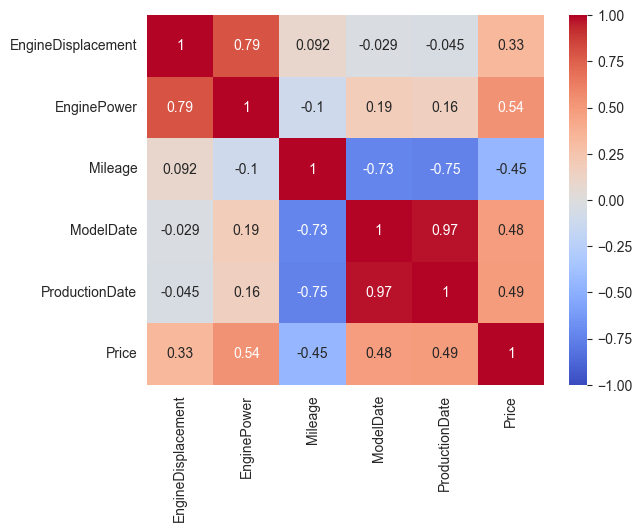

In [369]:
sb.heatmap(df_train[num_cols | {'Price'}].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

We see high correlation for 'EngineDisplacement' and 'EnginePower', and for 'ModelDate' and 'ProductionDate' features. Leave those which have greater correlation with target.

In [370]:
cols_to_del |= {'EngineDisplacement', 'ModelDate'}

Now let's see on mileage per year distributions:

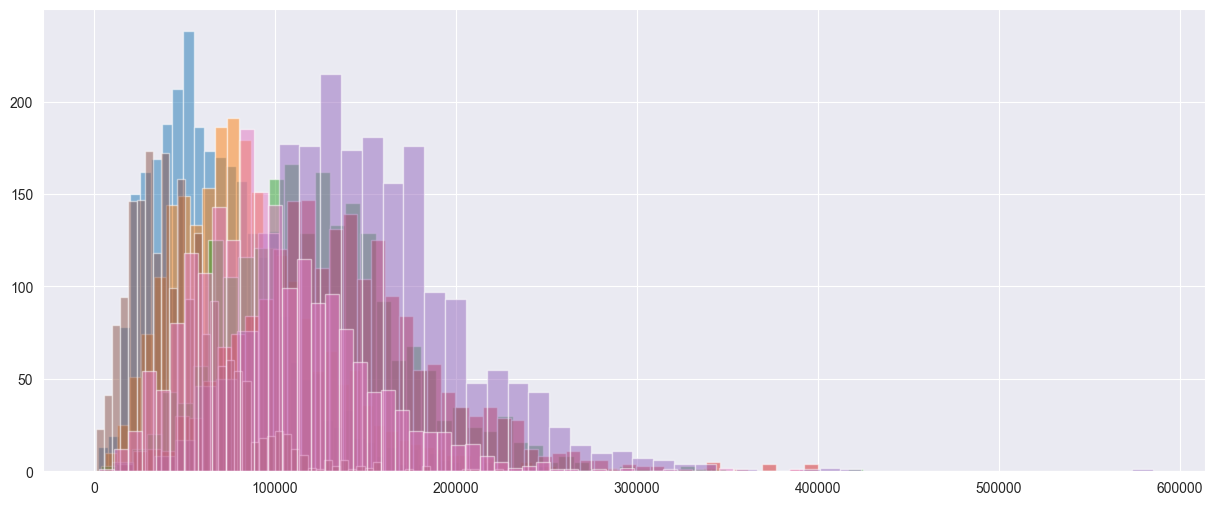

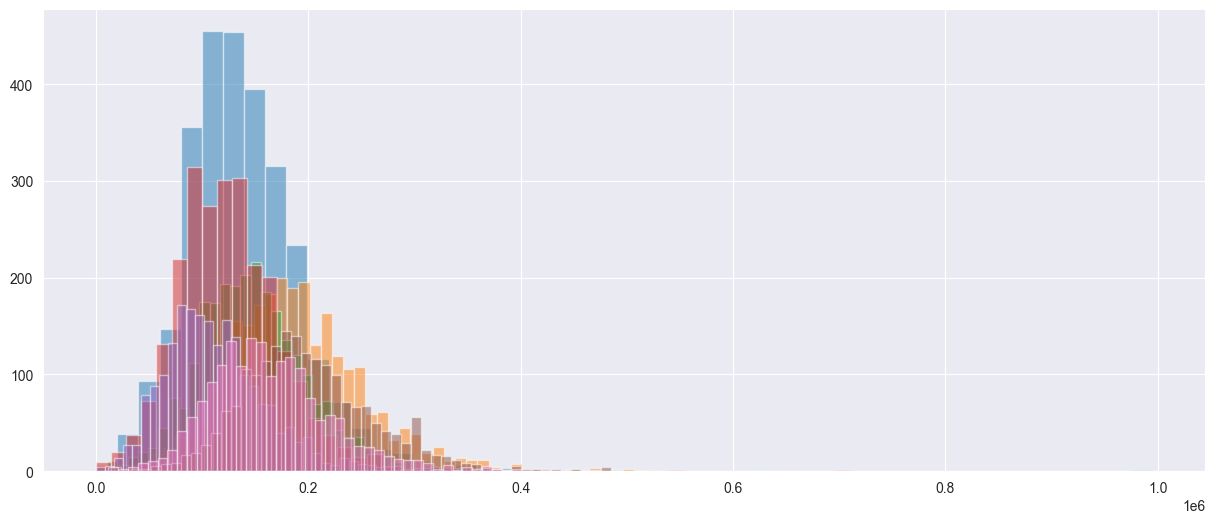

In [371]:

for df in dfs.values():
    plt.figure(figsize=(15, 6))
    for year in df['ProductionDate'].value_counts().index[:7]:
        df[df['ProductionDate'] == year]['Mileage'].hist(bins=50, alpha=0.5)


Distributions looks rather normal.
**PNF** So would be useful to create new feature for mileage per year.

### Categorical features

#### 'BodyType'

In [372]:
display(df_train['BodyType'].value_counts(dropna=False))
print('nunique =',df_train['BodyType'].nunique())
display(df_test['BodyType'].value_counts(dropna=False))
print('nunique =',df_test['BodyType'].nunique())

внедорожник 5 дв.          14238
седан                       9023
лифтбек                     2424
хэтчбек 5 дв.               1697
универсал 5 дв.              881
минивэн                      589
компактвэн                   433
купе                         428
хэтчбек 3 дв.                230
пикап двойная кабина         226
внедорожник 3 дв.             55
купе-хардтоп                  53
кабриолет                     51
микровэн                      35
фургон                        28
родстер                       24
седан-хардтоп                  4
пикап полуторная кабина        3
седан 2 дв.                    2
внедорожник открытый           1
лимузин                        1
пикап одинарная кабина         1
Name: BodyType, dtype: int64

nunique = 22


седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: BodyType, dtype: int64

nunique = 24


In [373]:
# no strange values or missings
# check
set(df_train['BodyType'].unique()) == set(df_test['BodyType'].unique())

False

In [374]:
# in train, but not in test
set(df_train['BodyType'].unique()).difference(set(df_test['BodyType'].unique()))

set()

In [375]:
# in test, but not in train
set(df_test['BodyType'].unique()).difference(set(df_train['BodyType'].unique()))

{'тарга', 'фастбек'}

In [376]:
# so, we have 2 body types in test that are not presented in train
# however it's just 3 cars from thousands - not a big deal, but think later what to do based on further analysis

In [377]:
# analyze category balance for train and test
show_countplot(df_train, 'BodyType', ordering=True)
show_countplot(df_test, 'BodyType', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [378]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'BodyType', 'Price', ordering=True)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Class balance is similar for train and test - it's good. Although first 2 positions of BodyType are swapped. And these first 2 positions are highly prevailed in number, but their price boxplots do not stay apart from other classes, so no need to create a new feature for just 2 most popular body types to predict price (as we see in other projects). Also we have noticeably less price for body type 'седан-хардтоп' but there are too small count for train and test - not a very good new feature.
In general boxplots for Price showed relatively high variability - could be useful for future model.
We lack 2 body types in train compared to test ('тарга' and 'фастбек'). But it's only 3 cars among thousands.
**TODO at Preparation Stage (TODO PS)** So we should ignore them in one-hot encoding at data preparation stage for this feature.

In [379]:
#

#### 'Brand'

In [380]:
display(df_train['Brand'].value_counts(dropna=False))
display(df_test['Brand'].value_counts(dropna=False))

HONDA         3254
LEXUS         2904
AUDI          2707
NISSAN        2707
TOYOTA        2703
SKODA         2701
VOLKSWAGEN    2677
BMW           2554
MITSUBISHI    2476
MERCEDES      2239
VOLVO         2164
INFINITI      1341
Name: Brand, dtype: int64

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: Brand, dtype: int64

In [381]:
# check if train and test values are equal
set(df_train['Brand'].unique()) == set(df_test['Brand'].unique())

True

Ok. Train and test brands are equal (as we know from parsing too).

In [382]:
# analyze category balance for train and test
show_countplot(df_train, 'Brand', ordering=True)
show_countplot(df_test, 'Brand', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [383]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'Brand', 'Price', ordering=True)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
We have comparable amount of records for different classes and for some of them train has more instances. Should be ok at training.
Boxplots for Price showed good variability - also left this feature to train on.

#### 'Color'

In [384]:
display(df_train['Color'].value_counts(dropna=False))
display(df_test['Color'].value_counts(dropna=False))


чёрный         8532
белый          7395
серый          4291
серебристый    2798
синий          2636
коричневый     1527
красный        1303
бежевый         514
зелёный         487
голубой         276
пурпурный       179
золотистый      158
фиолетовый      120
оранжевый       105
жёлтый           93
розовый          13
Name: Color, dtype: int64

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: Color, dtype: int64

In [385]:
# check if train and test values are equal
set(df_train['Color'].unique()) == set(df_test['Color'].unique())

True

Ok. We have same colors for train and test.

In [386]:
# analyze category balance for train and test
show_countplot(df_train, 'Color', ordering=True)
show_countplot(df_test, 'Color', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [387]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'Color', 'Price', ordering=True)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Color have very similar count distribution for train and test.
We have 2 much more popular colors - black and white, and their median prices are in top 3 high price "cluster" for color.
Also we have 3 rare and noticeably less expansive colors - green and pink.
**PNF**  Create new feature for 3 top (expensive) colors and 2 cheap colors.
Variability in price is rather good - left this feature to train on.

#### 'FuelType'

In [388]:
display(df_train['FuelType'].value_counts(dropna=False))
display(df_test['FuelType'].value_counts(dropna=False))

Бензин          21296
Дизель           7431
Гибрид           1271
оборудование      232
электро           119
Газ                65
гибрид             13
Name: FuelType, dtype: int64

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: FuelType, dtype: int64

In [389]:
# correct names to be as test
df_train['FuelType'] = df_train['FuelType'].apply(str.lower)
df_train['FuelType'].unique()

array(['бензин', 'дизель', 'газ', 'оборудование', 'гибрид', 'электро'],
      dtype=object)

In [390]:
# We see that train has one more class than test
set(df_train['FuelType'].unique()).difference(set(df_test['FuelType'].unique()))

{'оборудование'}

In [391]:
# don't need it for training -> delete

In [392]:
df_train.drop(df_train[df_train['FuelType'] == 'оборудование'].index, inplace=True)
df_train['FuelType'].unique()

array(['бензин', 'дизель', 'газ', 'гибрид', 'электро'], dtype=object)

In [393]:
# check if train and test values are equal now
set(df_train['FuelType'].unique()) == set(df_test['FuelType'].unique())

True

In [394]:
# analyze category balance for train and test
show_countplot(df_train, 'FuelType', ordering=True)
show_countplot(df_test, 'FuelType', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [395]:
# and boxplots for target
# there are some extreme values in Price column, so use quantile for boxplots
show_boxplot(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], 'FuelType', 'Price', ordering=True)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
FuelType feature have very similar count distribution for train and test.
Electro cars is the most expensive, but there are too little of them yet.
Variability in price is rather good.

#### 'ModelName'

In [396]:
display(df_train['ModelName'].value_counts(dropna=False))
display(df_test['ModelName'].value_counts(dropna=False))

OCTAVIA       1049
RX             996
POLO           885
OUTLANDER      857
QASHQAI        788
              ... 
SAFARI           1
NADIA            1
DAYZ             1
JUKE_NISMO       1
S3               1
Name: ModelName, Length: 467, dtype: int64

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: ModelName, Length: 544, dtype: int64

<AxesSubplot:>

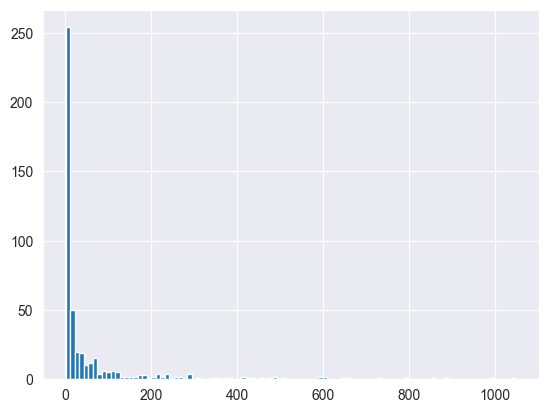

In [397]:
df_train['ModelName'].value_counts().hist(bins=100)

In [398]:
# TODO compare models train to test

In [399]:
# too high cardinality and many unique/low values
# let's see at least on top part
top_part = 0.7
model_cumsum_train = df_train['ModelName'].value_counts(normalize=True).cumsum()
models_top_train = df_train['ModelName'].value_counts()[model_cumsum_train < top_part]
display(models_top_train)

model_cumsum_test = df_test['ModelName'].value_counts(normalize=True).cumsum()
models_top_test = df_test['ModelName'].value_counts()[model_cumsum_test < top_part]
display(models_top_test)

OCTAVIA               1049
RX                     996
POLO                   885
OUTLANDER              857
QASHQAI                788
RAPID                  731
TIGUAN                 658
CAMRY                  650
CR_V                   603
ACCORD                 603
X_TRAIL                598
CIVIC                  588
XC90                   513
RAV_4                  491
5ER                    491
A4                     473
A6                     456
LX                     431
XC60                   430
3ER                    418
LANCER                 410
E_KLASSE               383
ES                     376
LAND_CRUISER_PRADO     347
NX                     340
Q7                     308
Q5                     290
X5                     289
KODIAQ                 288
LAND_CRUISER           286
ASX                    267
FX                     263
COROLLA                258
PASSAT                 256
S60                    242
PAJERO                 233
X3                     233
C

OCTAVIA               1418
5ER                   1026
LANCER                 855
E_KLASSE               809
PASSAT                 782
A6                     757
3ER                    752
POLO                   724
CAMRY                  709
X5                     675
X_TRAIL                654
A4                     626
QASHQAI                609
S_KLASSE               549
OUTLANDER              544
LAND_CRUISER           514
ALMERA                 502
TIGUAN                 491
TOUAREG                469
COROLLA                456
RAV_4                  447
C_KLASSE               428
GOLF                   424
LAND_CRUISER_PRADO     387
TEANA                  374
RAPID                  370
7ER                    343
M_KLASSE               343
XC90                   340
JETTA                  324
X6                     317
CIVIC                  316
PAJERO                 306
Q7                     302
FX                     297
X3                     283
JUKE                   268
A

In [400]:
# so now we have not so many models in selected top part of all presented cars in train and test, let's analyze them
print(f'model_top_train total = {len(models_top_train)}')
print(f'model_top_test total = {len(models_top_test)}')

# compare train and test values
models_top_diff = set(models_top_train.index).symmetric_difference(set(models_top_test.index))
print(models_top_diff)
print(f'model_top_diff  len = {len(models_top_diff)}')

models_top_common = set(models_top_train.index).intersection(set(models_top_test.index))
print(models_top_common)
print(f'model_top_common  len = {len(models_top_common)}')

model_top_train total = 53
model_top_test total = 57
{'GL_KLASSE', 'A8', 'M_KLASSE', 'SUPERB', 'Q3', 'KODIAQ', '7ER', 'GS', 'ES', 'S80', 'ASX', 'PRIMERA', 'MURANO', 'QX70', 'GOLF', '1ER', '80', 'TRANSPORTER', 'LX', 'ALMERA', 'A5', 'FIT', 'NX', 'TEANA'}
model_top_diff  len = 24
{'ACCORD', '5ER', 'PAJERO_SPORT', 'TOUAREG', 'RAPID', 'CIVIC', 'X6', 'RX', 'JUKE', 'PAJERO', 'POLO', 'X3', 'QASHQAI', 'Q5', 'XC90', 'CR_V', 'RAV_4', 'CAMRY', 'LAND_CRUISER', 'Q7', 'A6', 'OCTAVIA', 'PASSAT', 'E_KLASSE', 'LANCER', 'A3', 'X1', 'JETTA', 'X_TRAIL', '3ER', 'X5', 'S60', 'FABIA', 'TIGUAN', 'XC60', 'LAND_CRUISER_PRADO', 'C_KLASSE', 'OUTLANDER', 'A4', 'FX', 'COROLLA', 'S_KLASSE', 'YETI'}
model_top_common  len = 43


In [401]:
# analyze category balance for train and test (for common models in top part)
show_countplot(df_train[df_train['ModelName'].isin(models_top_common)], 'ModelName', ordering=True)
show_countplot(df_test[df_test['ModelName'].isin(models_top_common)], 'ModelName', ordering=True)


Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [402]:
# and boxplots for price for the most popular cars
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train[df_train['ModelName'].isin(models_top_common)],
            'ModelName', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [403]:
# also let's see on top price part of all common models to define maybe some "clusters" of expensive models
# all common models
models_common = set(df_train['ModelName'].unique()).intersection(set(df_test['ModelName'].unique()))
print(f'Train models: {len(df_train["ModelName"].unique())}, test models: {len(df_test["ModelName"].unique())}, models in common: {len(models_common)}')

models_only_in_train = set(df_train['ModelName'].unique()) - models_common
print('Number of models only in train:')
print(df_train[df_train['ModelName'].isin(models_only_in_train)].shape[0])

models_only_in_test  = set(df_test['ModelName'].unique()) - models_common
print('Number of models only in test:')
print(df_test[df_test['ModelName'].isin(models_only_in_test)].shape[0])

Train models: 467, test models: 544, models in common: 416
Number of models only in train:
220
Number of models only in test:
469


In [404]:
# we have not so many - 220 records for models that are not in test - delete them
print(df_train.shape)
df_train.drop(labels=df_train[df_train['ModelName'].isin(models_only_in_train)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)

(30195, 21)
(29975, 21)


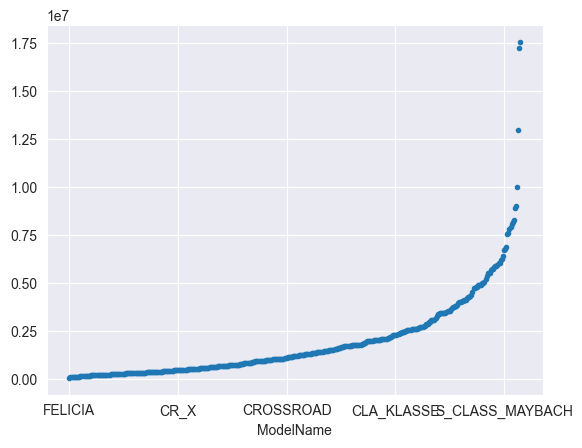

In [405]:
# plot all common models median price
model_price_medians = df_train[['ModelName', 'Price']][df_train['ModelName'].isin(models_common)].groupby(['ModelName']).median()
model_price_medians['Price'].sort_values().plot(style='.')
plt.grid(True)
plt.show()

In [406]:
# I would say that for these common models there is a "cluster" of expensive model with prices > 7.5 M,
# so based on plots above let's define expensive models (from common models set)
# as a model with price > 7.5M and NOT too old to become valuable not because of model but because of rarity
expensive_models = list(model_price_medians[model_price_medians['Price'] > 7.5*10**6].index.unique())
print(expensive_models)
print(len(expensive_models))
df_train[df_train['ModelName'].isin(expensive_models)].shape

['8ER', 'AMG_GT', 'E_TRON', 'GLC_KLASSE_AMG', 'G_KLASSE_AMG', 'I8', 'M5', 'Q8', 'R8', 'RS6', 'S8', 'W128', 'X7']
13


(251, 21)

In [407]:
# so we have 251 really expensive models

In [408]:
# # so based on plots above let's define expensive models (from common models set)
# # as a model with price > 5M and NOT too old to become valuable not because of model but because of rarity
# expensive_models = df_train[df_train['ModelName'].isin(model_top_common)
#                             & (df_train['Price'] > 5*10**6)
#                             & (df_train['ProductionDate'] > RARITY_YEAR)]['ModelName']
# expensive_models.value_counts()

Conclusion:
The distribution of cars model is very diverse (~ 500 different models). Meanwhile the most of dataset (70%) can be presented with only ~50 models and get a glance on their price distribution.
Train and test set are rather similar (same most popular model too) and models in test are well presented in train - it's good. Models that are only in train were deleted as not useful to predict.
It was interesting to compare price dependency for most popular and most expensive car models. Expectedly most popular models are not very expensive.
On price median plot for all car models we defined a cluster for most expensive car models (13 models and 251 records). And no distinctive cluster for cheap models.
**PNF** Create a new feature for expensive models.

Besides it would be useful to define most expensive model for particular brand and for same mileage intervals and create more new features, but let's stop on this for now.

#### 'NumberOfDoors'

In [409]:
df_train['NumberOfDoors'] = df_train['NumberOfDoors'].apply(int)

In [410]:
display(df_train['NumberOfDoors'].value_counts(dropna=False))
display(df_test['NumberOfDoors'].value_counts(dropna=False))

5    19750
4     9389
2      548
3      288
Name: NumberOfDoors, dtype: int64

5    18703
4    14126
2     1206
3      650
0        1
Name: NumberOfDoors, dtype: int64

In [411]:
# only one difference for only one car (the oldest cabriolet 1904 :) )

In [412]:
# analyze category balance for train and test
show_countplot(df_train, 'NumberOfDoors', ordering=True)
show_countplot(df_test, 'NumberOfDoors', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [413]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'NumberOfDoors', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Feature have very similar values balance for train and test.
Noticeable difference in price values for every category - should be good for model.
Test in contrast to train have a car with 0 number of doors, but it is a single car - not a problem for training.
**TODO PS** So we can ignore this category in one-hot encoding for test set at data preparation stage (not include this binary feature column and all other one-hot features will be zero for this car).


#### 'VehicleTransmission'

In [414]:
display(df_train['VehicleTransmission'].value_counts(dropna=False))
display(df_test['VehicleTransmission'].value_counts(dropna=False))

автоматическая      14794
механическая         7531
вариатор             4206
роботизированная     3444
Name: VehicleTransmission, dtype: int64

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: VehicleTransmission, dtype: int64

In [415]:
# check if train and test values are equal
set(df_train['VehicleTransmission'].unique()) == set(df_test['VehicleTransmission'].unique())

True

In [416]:
# analyze category balance for train and test
show_countplot(df_train, 'VehicleTransmission', ordering=True)
show_countplot(df_test, 'VehicleTransmission', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [417]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'VehicleTransmission', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Feature have very similar values balance for train and test.
Noticeable difference in price values for every category - should be good for model.

#### 'Owners'

In [418]:
display(df_train['Owners'].value_counts(dropna=False))
display(df_test['Owners'].value_counts(dropna=False))

1 владелец     11725
3 или более    10981
2 владельца     7269
Name: Owners, dtype: int64

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Owners, dtype: int64

In [419]:
# check if train and test values are equal
set(df_train['Owners'].unique()).symmetric_difference(set(df_test['Owners'].unique()))

{'1 владелец', '1\xa0владелец', '2 владельца', '2\xa0владельца'}

In [420]:
# correct test column a bit for similarity with train
df_test['Owners'] = df_test['Owners'].apply(lambda text: text.replace(u'\xa0',' '))

In [421]:
# check if train and test values are equal now
set(df_train['Owners'].unique()) == set(df_test['Owners'].unique())

True

In [422]:
# analyze category balance for train and test
show_countplot(df_train, 'Owners', ordering=True)
show_countplot(df_test, 'Owners', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [423]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers for this plot
show_boxplot(df_train, 'Owners', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Train and test sets are somewhat imbalanced, but difference is not critical.
Good price differentiation between categories and not many categories - good for one-hot encoding.

#### 'Drive'

In [424]:
display(df_train['Drive'].value_counts(dropna=False))
display(df_test['Drive'].value_counts(dropna=False))

полный      13923
передний    13549
задний       2503
Name: Drive, dtype: int64

передний    15565
полный      15020
задний       4101
Name: Drive, dtype: int64

In [425]:
# check if train and test values are equal
set(df_train['Drive'].unique()) == set(df_test['Drive'].unique())

True

In [426]:
# analyze category balance for train and test
show_countplot(df_train, 'Drive', ordering=True)
show_countplot(df_test, 'Drive', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [427]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Drive', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Train and test balance is very similar.
Mean is noticeably greater than median for all 3 categories -> big right skewness in price for this feature.
Good price differentiation between categories and not many categories - good for one-hot encoding.
Surprisingly (for me) rear-wheel drive turned out to be more expensive.

### Binary features

#### 'Vendor'

In [428]:
display(df_train['Vendor'].value_counts(dropna=False))
display(df_test['Vendor'].value_counts(dropna=False))

NaN    29975
Name: Vendor, dtype: int64

EUROPEAN    20682
JAPANESE    14004
Name: Vendor, dtype: int64

In [429]:
# let's infer this feature for train based on information in test
brand_vendor_dict = {k:v for k,v in df_test.groupby(['Brand','Vendor']).count().index}
print(brand_vendor_dict)
df_train['Vendor'] = df_train['Brand'].map(brand_vendor_dict)
df_train['Vendor'].value_counts()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MERCEDES': 'EUROPEAN', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'SKODA': 'EUROPEAN', 'TOYOTA': 'JAPANESE', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN'}


JAPANESE    15069
EUROPEAN    14906
Name: Vendor, dtype: int64

In [430]:
# analyze category balance for train and test
show_countplot(df_train, 'Vendor', ordering=True)
show_countplot(df_test, 'Vendor', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [431]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Vendor', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
We have some unbalance in train and test, but not critical.
See some differences in boxplots. Greater IQR for European cars and Japanese cars are slightly cheaper.

#### 'PTS'

In [432]:
display(df_train['PTS'].value_counts(dropna=False))
display(df_test['PTS'].value_counts(dropna=False))

Оригинал    26348
Дубликат     3627
Name: PTS, dtype: int64

Оригинал    30098
Дубликат     4587
NaN             1
Name: PTS, dtype: int64

In [433]:
# need to fill one NaN for test. Let's see on it
df_test_orig[df_test_orig['ПТС'].isna()]['car_url']

10412    https://auto.ru/cars/used/sale/bmw/3er/3350400...
Name: car_url, dtype: object

In [434]:
# nothing special - fill it with mode - 'Оригинал'
fillna_mode(df_test, 'PTS')

In [435]:
# check if train and test values are equal
set(df_train['PTS'].unique()) == set(df_test['PTS'].unique())

True

In [436]:
# analyze category balance for train and test
show_countplot(df_train, 'PTS', ordering=True)
show_countplot(df_test, 'PTS', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [437]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'PTS', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Train and test balance is very similar.
Significant difference in price between values. No one want to pay for weird case of 'Дубликат'. Supposedly good feature for price prediction.

#### 'Wheel'

In [438]:
display(df_train['Wheel'].value_counts(dropna=False))
display(df_test['Wheel'].value_counts(dropna=False))

Левый     28090
Правый     1885
Name: Wheel, dtype: int64

Левый     33287
Правый     1399
Name: Wheel, dtype: int64

In [439]:
# check if train and test values are equal
set(df_train['Wheel'].unique()) == set(df_test['Wheel'].unique())

True

In [440]:
# analyze category balance for train and test
show_countplot(df_train, 'Wheel', ordering=True)
show_countplot(df_test, 'Wheel', ordering=True)

Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [441]:
# and boxplots for target
# there are some extreme values in Price column, so don't show outliers
show_boxplot(df_train, 'Wheel', 'Price', ordering=True, showfliers=False)

Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


Conclusion:
Train and test balance is similar.
Significant difference in price between values. Right-wheel cars much more cheaper and has narrower price IQR. Supposedly good feature for price prediction.

### Target feature

In [442]:
analyze_num_col(df_train, 'Price', need_log=True, hist_bins=50)

Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


In [443]:
# Price has extreme outlier, let's see on it without them
vis_analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.99)],'Price', hist_bins=50)

Visualising function vis_analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).


We also should consider a parsing time for train and test sets, because our target variable price is changing over time.

In [444]:
for df in dfs.values():
    df['ParsingUnixtime'] = pd.to_datetime(df['ParsingUnixtime'], unit='s')
    df['ParsingUnixtime'] = pd.to_datetime(df['ParsingUnixtime'].dt.floor('d'))
    display(df['ParsingUnixtime'].value_counts().sort_index())

2022-02-02    29876
2022-02-06       99
Name: ParsingUnixtime, dtype: int64

2020-10-19     6441
2020-10-20     6813
2020-10-21    15907
2020-10-24     2123
2020-10-25     2944
2020-10-26      458
Name: ParsingUnixtime, dtype: int64

Conclusion:
Target variable Price distribution is very skewed to less values and has extreme outliers and not so small of them based on IQR (6 %). We don't know if something like this exist in test - maybe their removing before training could improve future results. Makes sense to try (maybe not if log transform).
Log transform of target feature seems much more normal (form, skewness near zero), has "better" value range, less number (2.3 %) and less values of outliers. Definitely should try log transform for target.

Test parsing date is 10.2020 and train parsing date is 02.2022 - 1.33 years diff. So, we should consider price changing during this period of time.
Based on information from [this page of autostat.ru](https://www.autostat.ru/infographics/48987/) and some other statistics, let's choose as start point for our experiments with price correction coefficient range [1.3 - 1.7]. But experiments result is the only truth for such a problem.

## New feature engineering

### Numeric

In [445]:
# let's create feature based on description column
# see on most frequent words for expensive and for cheap cars
expensive_cars = df_train[df_train['Price'] > df_train['Price'].quantile(0.9)]
cheap_cars = df_train[df_train['Price'] < df_train['Price'].quantile(0.1)]
print(expensive_cars.shape)
print(cheap_cars.shape)

(2988, 21)
(2928, 21)


In [446]:
n_1st_words = 200
expen_words_freq = expensive_cars['Description'].str.split(expand=True, n=n_1st_words).iloc[:, :n_1st_words].stack().value_counts()
expen_words_freq = expen_words_freq[expen_words_freq.index.map(lambda w: True if (len(w) > 3 and 'авто' not in w.lower()) else False)]
expen_words_freq

Система         3020
система         1860
пробегом        1766
безопасности    1610
сидений         1138
                ... 
жёсткостью.        1
электронно         1
переменной,        1
ride:              1
предоставлю        1
Length: 23690, dtype: int64

In [447]:
cheap_words_freq = cheap_cars['Description'].str.split(expand=True, n=n_1st_words).iloc[:, :n_1st_words].stack().value_counts()
cheap_words_freq = cheap_words_freq[cheap_words_freq.index.map(lambda w: True if (len(w) > 3 and 'авто' not in w.lower()) else False)]
cheap_words_freq

пробегом        536
хорошем         531
есть            515
работает        465
Машина          396
               ... 
12.5.1            1
предлагаете       1
варианты....      1
встретиться       1
нейтральной       1
Length: 24503, dtype: int64

In [448]:
test_descr_words = df_test['Description'].str.split(expand=True, n=n_1st_words).iloc[:,:n_1st_words].stack().value_counts()
test_descr_words = test_descr_words[test_descr_words.index.map(lambda w: True if (len(w)>3 and 'авто' not in w.lower()) else False)]
test_descr_words

пробегом         6988
Машина           5853
отличном         5235
есть             4667
только           4544
                 ... 
инетом,             1
плановый            1
ден"ги!!!           1
подарок(новая       1
неадекватные        1
Length: 163953, dtype: int64

Considering word frequency tables above and results of car pages analysis we will try to create feature ComplectationRank which indicates expensiveness of car complectation with function below:

In [449]:
def complectation_rank(description:str):
    descr = description.lower()
    rank = 0
    expensive_patterns = ['систем', 'датчик', 'круиз', 'многозонный', 'безопасности пассажир',
                          'безопасности боков', 'глонас', 'парктроник', 'камер', r'\bкож']

    for pattern in expensive_patterns:
        if re.search(pattern, descr):
            rank += 1
    return rank

In [450]:
# create new numerical features (for train and test)
for key, df in dfs.items():
    # add ComplectationRank via funciton above
    df['ComplectationRank'] = df['Description'].apply(complectation_rank)

    # also try words count for Description
    df['DescrWordsCount'] = df['Description'].apply(lambda s: len(s.split()))

    # age of the car
    parsing_date = 2022 if key == 'train' else 2020
    df['Age'] = parsing_date - df['ProductionDate']

    # mileage per year
    df['MileagePerYear'] = df['Mileage'] / df['Age']
    df['MileagePerYear'].replace([np.inf, -np.inf], 0, inplace=True)

    # count of years for one owner
    # well, we have not numeric value '3 и БОЛЕЕ' in Owners that makes this feature somewhat questionable
    # but let's experiment with it, perhaps we will see if there is a tendency
    df['YearsPerOwner'] = df['Age'] / df['Owners'].apply(lambda s:int(s[0]))

# add new numeric columns in separate list
new_num_cols = OrderedSet(['ComplectationRank', 'DescrWordsCount', 'Age', 'MileagePerYear', 'YearsPerOwner'])

In [451]:
# analyze new numeric features
for col in new_num_cols:
    print_framed(col)
    analyze_num_col(df_train[df_train['Price'] < df_train['Price'].quantile(0.98)], col, 'Price', need_log=True, hist_bins=50, hist2d_x_bins=40, hist2d_y_bins=30)


****************************************************************************************************
************************************     ComplectationRank     ************************************
****************************************************************************************************
Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
****************************************************************************************************
*************************************     DescrWordsCount     *************************************
****************************************************************************************************
Visualising function analyze_num_col() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
****************************************************************************************************
***************************

<AxesSubplot:>

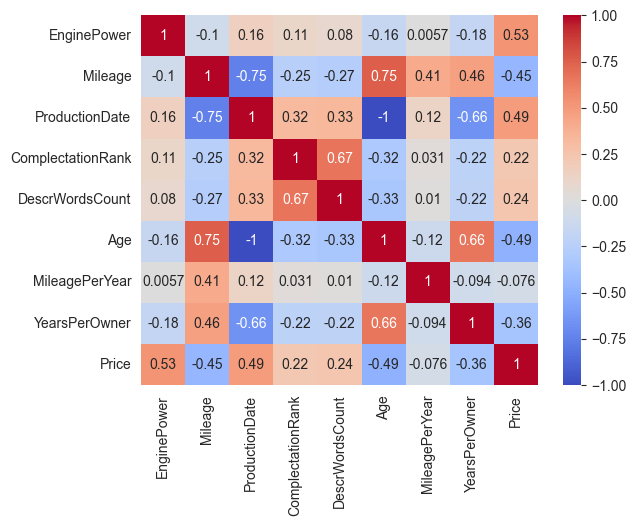

In [452]:
# correlation analysis for all numeric features
sb.heatmap(df_train[(num_cols | new_num_cols) - cols_to_del | {'Price'}].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

Conclusion:
'ComplectationRank'
We can see expected correlation with 'DescrWordsCount' feature, but not extreme. And as described earlier there is some correlation with price - visually and by corr coefficient (0.28 for price 0.98 percentile and 0.22 for all records). Leave this feature.
Log transofrm seems not to be helpful due to distribution form and corr coefficients comparing to original data. Don't use log transform for this feature.

'DescrWordsCount'
There is also some visual and numeric correlation with price. Let's leave this feature. Don't use log transform.

'Age'
We can see strong correlation with ProductionDate and considerable correlation with Mileage. Decide to leave Age feature because of 2 points:
1. Age have more relative difference between values compared to ProductionDate
2. Age wouldn't have this shift between train and test compared to ProductionDate feature due to their different parsing time. For example for ProductionDate = 2010 for train set all dependencies would be like for 12 years old car, but for test ProductionDate 2010 - it is only 10 years old

'MileagePerYear'
We can see almost no correlation with price. Maybe just a little positive (surprisingly) from visual analysis of scatter for small number of observations. But let's leave the feature for experiments. No sense to log transform.

'YearsPerOwner'
We can see some negative (a bit surprisingly) correlation (corr coeff = -0.42 for 0.98 percentile). Cars which belonged to one owner long time cost less. Maybe it is like an indicator of car liquidity. Interesting dependency. We remember that this is rather questionable feature, but let's try it and decide about its usefulness later.
Decide to log transform this feature due to greater corr coef for log transformed data.

In [453]:
cols_to_del |= {'ProductionDate'}
cols_to_log |= {'YearsPerOwner'}

### Qualitative

In [454]:
# create new qualitative features (for train and test)
for df in dfs.values():
    # car rarity flag
    df['Rarity'] = df['Age'].apply(lambda age: 1 if age > 45 else 0)

    # 3 top (expensive) colors
    df['ExpensiveColor'] = df['Color'].apply(lambda c: 1 if c in ['чёрный','белый','коричневый'] else 0)

    # and 3 cheap colors
    df['CheapColor'] = df['Color'].apply(lambda c: 1 if c in ['зелёный','розовый'] else 0)

    # expensive models - which are in list we defined earlier
    df['ExpensiveModel'] = df['ModelName'].apply(lambda n: 1 if n in expensive_models else 0)

# add new bin columns in separate list
new_bin_cols = OrderedSet(['Rarity', 'ExpensiveColor', 'CheapColor', 'ExpensiveModel'])

In [455]:
# let's analyze new features
for col in new_bin_cols:
    print_framed(col)
    print('For train:')
    show_countplot(df_train, col, ordering=True)
    show_boxplot(df_train, col, 'Price', ordering=True, showfliers=False)
    print('For test:')
    show_countplot(df_test, col, ordering=True)

****************************************************************************************************
******************************************     Rarity     ******************************************
****************************************************************************************************
For train:
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
Visualising function show_boxplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
For test:
Visualising function show_countplot() was skipped due to false value of visualisation flag VISUALIZE (defined in Constants section).
****************************************************************************************************
**************************************     ExpensiveColor     **************************************
*****************************************************************************

Most of our new binary features have very small count of records, but all of them as we planned have significant difference in price boxplots, hope this will help.

Now we finished with EDA and feature engineering and ready to start feature preparation stage.

In [456]:
cols_to_del

OrderedSet(['EngineDisplacement', 'ModelDate', 'ProductionDate'])

In [457]:
# add already unnecessary features to deletion
cols_to_del |= {'SuperGen', 'ParsingUnixtime', 'Description'}
cols_to_del |= qual_cols | new_bin_cols

# and delete all unnecessary features
for df in dfs.values():
    df.drop(columns=cols_to_del, inplace=True)
    df.info()

# keep cols lists up to date

num_cols -= cols_to_del
cat_cols -= cols_to_del
bin_cols -= cols_to_del
qual_cols -= cols_to_del

new_num_cols -= cols_to_del
new_bin_cols -= cols_to_del


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29975 entries, 0 to 29974
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EnginePower        29975 non-null  float64
 1   Mileage            29975 non-null  float64
 2   Price              29975 non-null  float64
 3   ComplectationRank  29975 non-null  int64  
 4   DescrWordsCount    29975 non-null  int64  
 5   Age                29975 non-null  float64
 6   MileagePerYear     29975 non-null  float64
 7   YearsPerOwner      29975 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EnginePower        34686 non-null  int64  
 1   Mileage            34686 non-null  int64  
 2   ComplectationRank  34686 non-null  int64  
 3   DescrWord

## Feature preparation and encoding

In [458]:
# So what we have in feature lists
num_cols, cat_cols, bin_cols, cols_to_log

(OrderedSet(['EnginePower', 'Mileage']),
 OrderedSet(),
 OrderedSet(),
 OrderedSet(['EnginePower', 'YearsPerOwner']))

In [459]:
new_num_cols, new_bin_cols

(OrderedSet(['ComplectationRank', 'DescrWordsCount', 'Age', 'MileagePerYear', 'YearsPerOwner']),
 OrderedSet())

In [460]:
df_train[qual_cols].nunique()

Series([], dtype: float64)

In [461]:
# there is no clear natural ordering in our categorical features
# (it could be owners, but we didn't see monotonic change in price and it's more like category)
# (it could be number of doors, but the same argument and it's more like category too)
# so no label encoding, all to OneHot for now.
# except ModelName feature with too high cardinality - will try binary encoding for it
# binary_encoding = {'ModelName'}
binary_encoding = {}
onehot_encoding = cat_cols - binary_encoding
label_encoding = bin_cols

# # remember that we should delete some encoded columns for BodyType in test
# # because they are absent in train and we can't use our model without this step
# onehot_encoding['BodyType'] = {'not in train':['тарга', 'фастбек']}

In [462]:
# df_train_enc = df_train.copy()
# df_test_enc = df_test.copy()

df_train['Train'] = 1
df_test['Train'] = 0
df_comb = pd.concat([df_train, df_test], ignore_index=True)

for col in onehot_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))

    df_comb = pd.get_dummies(df_comb, prefix=[col], columns=[col])

    # remove from combined data dummy cols that not in train - have no choice with this train..
    df_comb.drop(columns=[col+'_' + str(val) for val in vals_no_train], axis=1, inplace=True)

for col in label_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))
    start_idx = 1 if vals_no_train else 0
    labels_mapping = {cat:label for label,cat in enumerate(df_comb[col].unique(), start=start_idx)}
    labels_mapping.update({cat:0 for cat in vals_no_train})

    df_comb[col] = df_comb[col].map(labels_mapping)

for col in binary_encoding:
    vals_no_train = set(df_test[col].unique()).difference(set(df_train[col].unique()))

    df_comb[col] = df_comb[col].apply(lambda v: None if v in vals_no_train else v)
    bin_enc = BinaryEncoder(cols=[col])

    df_comb = bin_enc.fit_transform(df_comb, handle_missing='value')

In [463]:
# log transform defined features
for col in cols_to_log:
    df_comb[f'{col}_log'] = log_transform(df_comb[col])
    df_comb.drop(columns=[col], axis=1, inplace=True)

df_comb

,Mileage,Price,ComplectationRank,DescrWordsCount,Age,MileagePerYear,Train,EnginePower_log,YearsPerOwner_log
0,98000.0,1030000.0,2,26,8.0,12250.000000,1,5.198497,2.197225
1,239000.0,400000.0,1,155,14.0,17071.428571,1,5.017280,2.079442
2,2000.0,1820000.0,5,384,2.0,1000.000000,1,4.709530,1.098612
3,156000.0,730000.0,2,207,5.0,31200.000000,1,4.812184,1.252763
4,50000.0,2250000.0,6,427,6.0,8333.333333,1,5.198497,1.945910
...,...,...,...,...,...,...,...,...,...
64656,115000.0,NaN,0,60,6.0,19166.666667,0,4.919981,1.098612
64657,98000.0,NaN,0,3,2.0,49000.000000,0,5.252273,1.098612
64658,360000.0,NaN,0,2,23.0,15652.173913,0,5.141664,2.159484
64659,90500.0,NaN,2,75,7.0,12928.571429,0,5.220356,1.504077


## Learning

In [476]:
X = df_comb[df_comb['Train'] == 1].drop(columns=['Price', 'Train']).values
X_sub = df_comb[df_comb['Train'] == 0].drop(columns=['Price', 'Train']).values
y = df_comb[df_comb['Train'] == 1]['Price']
print(X.shape)
print(X_sub.shape)
print(y.shape)

(29975, 7)
(34686, 7)
(29975,)


In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
y_train_log = log_transform(y_train)
y_test_log = log_transform(y_test)

print(X_train.shape)
print(X_test.shape)

(23980, 7)
(5995, 7)


### Simple model (linear regression)

In [607]:

X_train_cur = X_train
# X_train_cur = MinMaxScaler().fit_transform(X_train_cur)

# lin_reg = LinearRegression(positive=True)
# lin_reg.fit(X_train_cur, y_train_log)
# y_pred_log = lin_reg.predict(X_test)


reg_pipe = Pipeline([('mms', StandardScaler()),
                     ('Lasso', Lasso(max_iter=10_000))])

params = [{'Lasso__alpha': np.logspace(-4,9,20)}]

reg_model = GridSearchCV(reg_pipe, param_grid=params, scoring='neg_mean_absolute_percentage_error' ,cv=3, n_jobs=-1)

reg_model.fit(X_train_cur, y_train)
y_pred = reg_model.predict(X_test)

reg_model.fit(X_train_cur, y_train_log)
y_pred_log = reg_model.predict(X_test)

y_mape_log = mape(y_pred_log, y_test_log)
y_mape_inv_log = mape(inv_log_transform(y_pred_log), y_test)
y_mape = mape(y_pred, y_test)


print(f'y_mape_log = {y_mape_log}, y_mape_inv_log = {y_mape_inv_log}, y_mape = {y_mape}')


y_mape_log = 0.019020811255474928, y_mape_inv_log = 0.2776060965932397, y_mape = 0.594947808303706


In [606]:
X_train_cur

array([[2.23000000e+05, 1.00000000e+00, 3.00000000e+02, ...,
        1.17368421e+04, 4.41884061e+00, 1.99243016e+00],
       [1.00000000e+03, 1.00000000e+00, 1.43000000e+02, ...,
        1.00000000e+03, 5.16478597e+00, 6.93147181e-01],
       [3.00000000e+03, 1.00000000e+00, 9.60000000e+01, ...,
        1.00000000e+03, 5.80211838e+00, 1.38629436e+00],
       ...,
       [4.00000000e+03, 0.00000000e+00, 1.80000000e+01, ...,
        1.33333333e+03, 5.73979291e+00, 1.38629436e+00],
       [5.79000000e+05, 0.00000000e+00, 1.68000000e+02, ...,
        3.04736842e+04, 5.46383181e+00, 1.99243016e+00],
       [1.73000000e+05, 0.00000000e+00, 1.05000000e+02, ...,
        1.44166667e+04, 4.33073334e+00, 1.60943791e+00]])

In [608]:
reg_model.best_params_
reg_model.best_estimator_['Lasso'].coef_

array([-0.11686137,  0.01856906,  0.02431637, -0.49724249,  0.0039171 ,
        0.38018176, -0.00258318])

In [595]:
df_test

,EnginePower,Mileage,ComplectationRank,DescrWordsCount,Age,MileagePerYear,YearsPerOwner,Train
0,105,74000,0,145,6,12333.333333,2.000000,0
1,110,60563,3,357,3,20187.666667,3.000000,0
2,152,88000,0,145,6,14666.666667,6.000000,0
3,110,95000,1,238,6,15833.333333,6.000000,0
4,152,58536,3,322,8,7317.000000,8.000000,0
...,...,...,...,...,...,...,...,...
34681,136,115000,0,60,6,19166.666667,2.000000,0
34682,190,98000,0,3,2,49000.000000,2.000000,0
34683,170,360000,0,2,23,15652.173913,7.666667,0
34684,184,90500,2,75,7,12928.571429,3.500000,0


[0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1        0.21544347 0.46415888 1.        ]


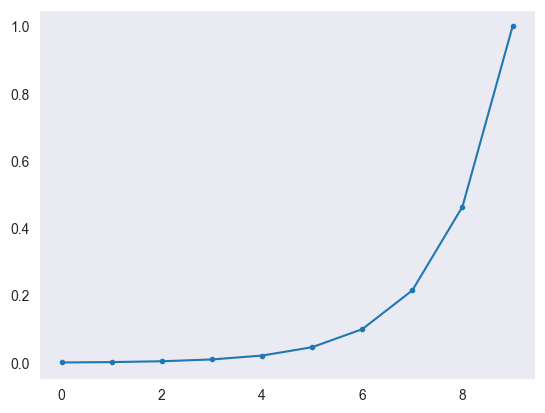

In [561]:
space= np.logspace(-3,0 ,10)
plt.plot(range(0,10),space, marker='.')
print(space)

In [508]:
# y_pred_log
X_train_cur
y_train_log
y_pred_log - y_test_log

4877     0.811286
2275    -0.060552
11422    0.014956
20882   -1.255392
7182     0.902258
           ...   
16371   -0.375141
17172   -1.045916
23787   -0.491940
8282     0.249603
29718    0.886510
Name: Price, Length: 5995, dtype: float64

In [ ]:
# save submission for algorithm
y_pred_subm_log = lin_reg.predict(X_sub)
y_pred_subm = inv_log_transform(y_pred_subm_log)

df_sub = df_test_orig['sell_id'].copy()
df_sub['price'] = y_pred_subm

# Trials